In [7]:
import numpy as np

def parse_intel_log_with_timestamps(file_path):
    """
    Parse the raw INTEL log file to extract odometry and LiDAR data with timestamps.

    Args:
        file_path (str): Path to the raw-log file.

    Returns:
        tuple: (odometry, lidar, odometry_timestamps, lidar_timestamps)
    """
    odometry = []
    lidar_scans = []
    odometry_timestamps = []
    lidar_timestamps = []

    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == "ODOM":
                # Extract odometry: x, y, theta
                x, y, theta = map(float, parts[1:4])
                odometry.append((x, y, theta))
                odometry_timestamps.append(float(parts[-3]))  # Adjusted timestamp position
            elif parts[0] == "FLASER":
                # Extract LiDAR ranges
                num_readings = int(parts[1])
                ranges = list(map(float, parts[2:2 + num_readings]))
                lidar_scans.append(ranges)
                lidar_timestamps.append(float(parts[-3]))  # Adjusted timestamp position

    return (
        np.array(odometry),
        np.array(lidar_scans),
        np.array(odometry_timestamps),
        np.array(lidar_timestamps),
    )

# Path to the raw-log file
file_path = "./data/intel.log"

# Parse the log file
odometry_data, lidar_data, odometry_timestamps, lidar_timestamps = parse_intel_log_with_timestamps(file_path)

# Check parsed shapes
print(f"Odometry Data Shape: {odometry_data.shape}")
print(f"LiDAR Data Shape: {lidar_data.shape}")
print(f"Odometry Timestamps Shape: {odometry_timestamps.shape}")
print(f"LiDAR Timestamps Shape: {lidar_timestamps.shape}")


Odometry Data Shape: (26915, 3)
LiDAR Data Shape: (13631, 180)
Odometry Timestamps Shape: (26915,)
LiDAR Timestamps Shape: (13631,)


In [9]:
def preprocess_lidar(lidar_data, max_range=10.0, target_points=90):
    """
    Normalize and downsample LiDAR data.

    Args:
        lidar_data (numpy.ndarray): LiDAR data.
        max_range (float): Maximum range for normalization.
        target_points (int): Number of points to keep after downsampling.

    Returns:
        numpy.ndarray: Processed LiDAR data.
    """
    # Normalize distances
    lidar_data = np.clip(lidar_data / max_range, 0, 1)
    # Downsample
    factor = lidar_data.shape[1] // target_points
    return lidar_data[:, ::factor]

processed_lidar = preprocess_lidar(aligned_lidar)

# Extract steering angle (theta) from odometry
steering_angles = aligned_odometry[:, 2]

# Final shapes
print(f"Processed LiDAR Shape: {processed_lidar.shape}")
print(f"Steering Angles Shape: {steering_angles.shape}")


Processed LiDAR Shape: (12514, 90)
Steering Angles Shape: (12514,)


In [10]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    processed_lidar, steering_angles, test_size=0.2, random_state=42
)

print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")


Training Data Shape: (10011, 90), (10011,)
Testing Data Shape: (2503, 90), (2503,)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegularizedLiDARNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout_rate=0.3):
        super(RegularizedLiDARNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the model
model = RegularizedLiDARNet(input_dim=X_train.shape[1], dropout_rate=0.3)
print(model)


RegularizedLiDARNet(
  (fc): Sequential(
    (0): Linear(in_features=90, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [13]:
from torch.utils.data import DataLoader, TensorDataset
import itertools

# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Hyperparameter grid
hyperparams = {
    "learning_rates": [0.001, 0.005, 0.01],
    "batch_sizes": [16, 32, 64],
    "dropout_rates": [0.2, 0.3, 0.4],
}

# Hyperparameter tuning
results = []
for lr, batch_size, dropout_rate in itertools.product(
    hyperparams["learning_rates"], hyperparams["batch_sizes"], hyperparams["dropout_rates"]
):
    print(f"Testing lr={lr}, batch_size={batch_size}, dropout_rate={dropout_rate}")

    # Create a new model
    model = RegularizedLiDARNet(input_dim=X_train.shape[1], dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in range(10):  # Use fewer epochs during tuning
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            test_loss += criterion(outputs, batch_y).item()

    test_loss /= len(test_loader)  # Average test loss
    print(f"Test Loss: {test_loss:.4f}")
    results.append((lr, batch_size, dropout_rate, test_loss))

# Find the best hyperparameters
best_config = sorted(results, key=lambda x: x[3])[0]
print(f"Best Hyperparameters: Learning Rate={best_config[0]}, Batch Size={best_config[1]}, Dropout Rate={best_config[2]}")


Testing lr=0.001, batch_size=16, dropout_rate=0.2
Test Loss: 2.9802
Testing lr=0.001, batch_size=16, dropout_rate=0.3
Test Loss: 3.1023
Testing lr=0.001, batch_size=16, dropout_rate=0.4
Test Loss: 3.2373
Testing lr=0.001, batch_size=32, dropout_rate=0.2
Test Loss: 2.9374
Testing lr=0.001, batch_size=32, dropout_rate=0.3
Test Loss: 3.1293
Testing lr=0.001, batch_size=32, dropout_rate=0.4
Test Loss: 3.2372
Testing lr=0.001, batch_size=64, dropout_rate=0.2
Test Loss: 3.0102
Testing lr=0.001, batch_size=64, dropout_rate=0.3
Test Loss: 3.1382
Testing lr=0.001, batch_size=64, dropout_rate=0.4
Test Loss: 3.2397
Testing lr=0.005, batch_size=16, dropout_rate=0.2
Test Loss: 3.4911
Testing lr=0.005, batch_size=16, dropout_rate=0.3
Test Loss: 3.5109
Testing lr=0.005, batch_size=16, dropout_rate=0.4
Test Loss: 3.5416
Testing lr=0.005, batch_size=32, dropout_rate=0.2
Test Loss: 3.3728
Testing lr=0.005, batch_size=32, dropout_rate=0.3
Test Loss: 3.4318
Testing lr=0.005, batch_size=32, dropout_rate=0.

In [16]:
# Final training with the best hyperparameters
best_lr = 0.001
best_batch_size = 32
best_dropout_rate = 0.2

# Initialize the model with the best dropout rate
model = RegularizedLiDARNet(input_dim=X_train.shape[1], dropout_rate=best_dropout_rate)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=best_lr)
criterion = nn.MSELoss()

# Create DataLoader with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluate on test data
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}"
    )


Epoch [1/20], Train Loss: 3.6341, Test Loss: 3.6545
Epoch [2/20], Train Loss: 3.5687, Test Loss: 3.5458
Epoch [3/20], Train Loss: 3.4818, Test Loss: 3.5061
Epoch [4/20], Train Loss: 3.3757, Test Loss: 3.3915
Epoch [5/20], Train Loss: 3.3003, Test Loss: 3.2606
Epoch [6/20], Train Loss: 3.2122, Test Loss: 3.2268
Epoch [7/20], Train Loss: 3.1093, Test Loss: 3.0957
Epoch [8/20], Train Loss: 3.0397, Test Loss: 3.0460
Epoch [9/20], Train Loss: 2.9661, Test Loss: 2.9927
Epoch [10/20], Train Loss: 2.8879, Test Loss: 2.9033
Epoch [11/20], Train Loss: 2.8381, Test Loss: 2.8464
Epoch [12/20], Train Loss: 2.7760, Test Loss: 2.8551
Epoch [13/20], Train Loss: 2.7437, Test Loss: 2.7912
Epoch [14/20], Train Loss: 2.6719, Test Loss: 2.7533
Epoch [15/20], Train Loss: 2.6395, Test Loss: 2.7491
Epoch [16/20], Train Loss: 2.5779, Test Loss: 2.6336
Epoch [17/20], Train Loss: 2.5251, Test Loss: 2.5939
Epoch [18/20], Train Loss: 2.5007, Test Loss: 2.5578
Epoch [19/20], Train Loss: 2.4386, Test Loss: 2.5987
Ep

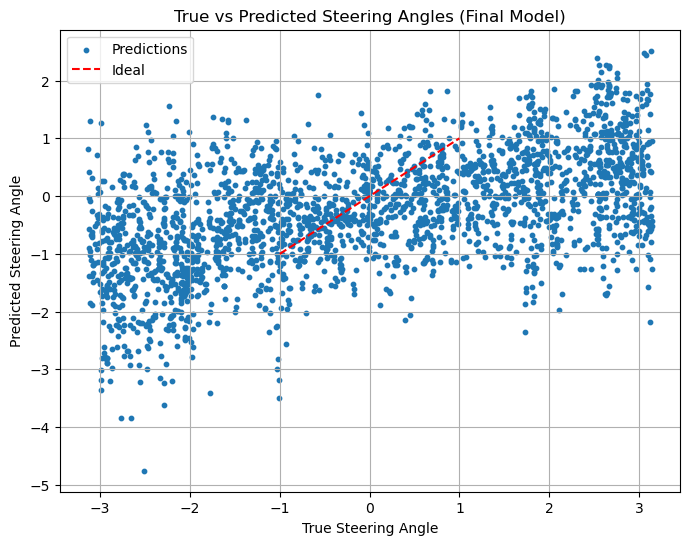

In [17]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().numpy()

# Compare predictions to ground truth
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, s=10, label="Predictions")
plt.plot([-1, 1], [-1, 1], color="red", linestyle="--", label="Ideal")
plt.title("True vs Predicted Steering Angles (Final Model)")
plt.xlabel("True Steering Angle")
plt.ylabel("Predicted Steering Angle")
plt.grid()
plt.legend()
plt.show()


In [18]:
# Save the model
torch.save(model.state_dict(), "lidar_model.pth")
print("Model saved as lidar_model.pth")


Model saved as lidar_model.pth


In [ ]:
import torch

# Export to ONNX
dummy_input = torch.randn(1, X_train.shape[1], dtype=torch.float32)  # Example input
torch.onnx.export(
    model,
    dummy_input,
    "final_lidar_model.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11  # Use ONNX opset version 11 or higher
)
print("Model exported to ONNX format as final_lidar_model.onnx")


### then, in jetson nano
## Convert ONNX to TensorRT
# trtexec --onnx=final_lidar_model.onnx --saveEngine=final_lidar_model.trt --fp16



Model exported to ONNX format as final_lidar_model.onnx


Input Name: input, Output Name: output
Processed Test Data Shape: (2503, 90)


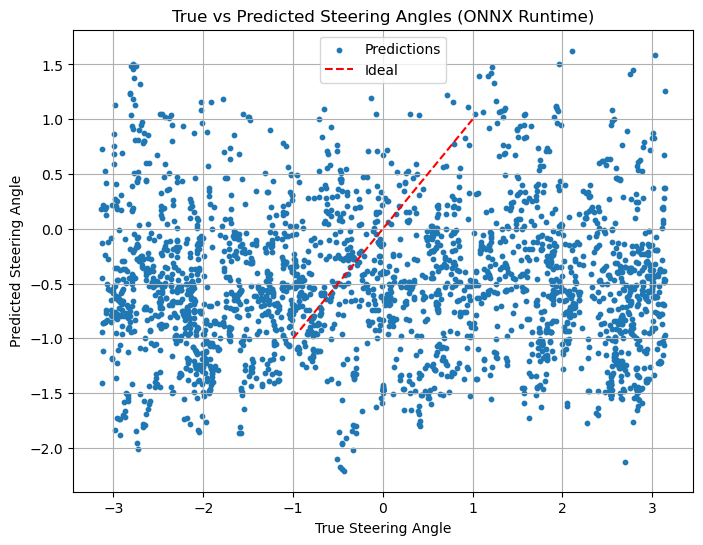

In [28]:
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

# Load ONNX model
onnx_model_path = "final_lidar_model.onnx"
session = ort.InferenceSession(onnx_model_path)

# Get input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print(f"Input Name: {input_name}, Output Name: {output_name}")

# Define preprocessing function
def preprocess_lidar(lidar_scan, max_range=10.0, target_points=90):
    # Normalize distances
    lidar_scan = np.clip(lidar_scan / max_range, 0, 1)  # Normalize to [0, 1]
    # Downsample to the target number of points
    factor = len(lidar_scan) // target_points
    lidar_scan = lidar_scan[::factor]  # Downsample
    return lidar_scan.astype(np.float32).reshape(1, -1)  # Ensure correct shape

# Preprocess the test dataset and ensure it's float32
processed_test_data = np.array([preprocess_lidar(scan).flatten() for scan in X_test], dtype=np.float32)
print(f"Processed Test Data Shape: {processed_test_data.shape}")

# Define ONNX inference function
def onnx_predict(lidar_scan):
    # Ensure the input data type is float32
    lidar_scan = lidar_scan.astype(np.float32)  # Convert to float32

    # Perform inference
    result = session.run([output_name], {input_name: lidar_scan})
    return result[0][0][0]  # Extract the predicted value

# Evaluate ONNX model on the processed test dataset
predictions = []
for lidar_scan in processed_test_data:
    predicted_steering = onnx_predict(lidar_scan.reshape(1, -1))  # Reshape input
    predictions.append(predicted_steering)

# Compare predictions to ground truth
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, s=10, label="Predictions")
plt.plot([-1, 1], [-1, 1], color="red", linestyle="--", label="Ideal")
plt.title("True vs Predicted Steering Angles (ONNX Runtime)")
plt.xlabel("True Steering Angle")
plt.ylabel("Predicted Steering Angle")
plt.grid()
plt.legend()
plt.show()
